In [1]:
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt 
import pandas as pd 
from scipy.optimize import minimize
import matplotlib.ticker as mtick 

In [2]:
inicio = dt.date(2015, 1, 1)
final = dt.date(2022, 12, 31)

In [3]:
lista_acoes = ["AAPL", "NKE", "GOOGL", "AMZN"]

precos = yf.download(lista_acoes, inicio, final)['Adj Close']

[*********************100%%**********************]  4 of 4 completed


In [4]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna()
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

In [5]:
numero_carteiras = 10000
vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):

    pesos = np.random.random(len(lista_acoes))
    pesos = pesos/np.sum(pesos)
    tabela_pesos[k, :] = pesos

    vetor_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    vetor_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))

    vetor_sharpe[k] = vetor_retornos_esperados[k]/vetor_volatilidades_esperadas[k]

In [6]:
indice_do_sharpe_maximo = vetor_sharpe.argmax()

tabela_pesos[indice_do_sharpe_maximo]

array([0.60128651, 0.33993066, 0.01843169, 0.04035115])

In [7]:
tabela_retornos_esperados_arit = np.exp(vetor_retornos_esperados) - 1

tabela_retornos_esperados_arit

array([0.2190031 , 0.19997449, 0.2139247 , ..., 0.18771844, 0.19132327,
       0.18532726])

In [12]:
eixo_y_fronteira_eficiente = np.linspace(tabela_retornos_esperados_arit.min(), tabela_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos + peso_teste) * 252
    retorno = np.exp(retorno) - 1

    return retorno

def checando_soma_pesos(peso_teste):

    return np.sum(peso_teste)-1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))

    return vol

peso_inicial = [1/len(lista_acoes)] *len(lista_acoes)

limites = tuple([(0, 1) for ativo in lista_acoes])

eixo_x_fronteira_eficiente = []

for retorno_possivel in eixo_y_fronteira_eficiente:

    restricoes = ({'type':'eq', 'fun':checando_soma_pesos},{'type':'eq','fun': lambda w: pegando_retorno(w) - retorno_possivel})
    result = minimize(pegando_vol, peso_inicial, method='SLSQP',bounds=limites, constraints = restricoes)
    eixo_x_fronteira_eficiente.append(result['fun'])

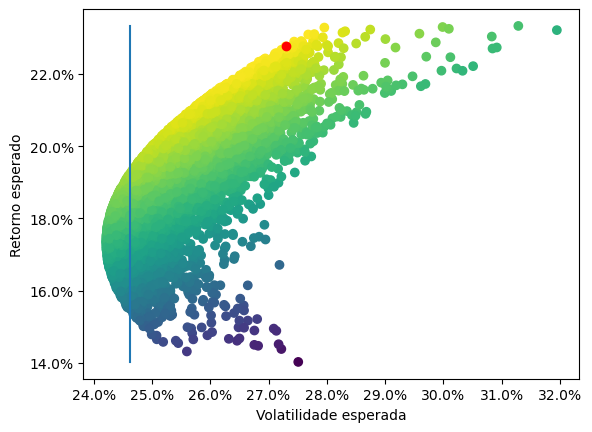

In [19]:
fig, ax=plt.subplots()

ax.scatter(vetor_volatilidades_esperadas, tabela_retornos_esperados_arit, c = vetor_sharpe)
plt.xlabel("Volatilidade esperada")
plt.ylabel("Retorno esperado")
ax.scatter(vetor_volatilidades_esperadas[indice_do_sharpe_maximo], tabela_retornos_esperados_arit[indice_do_sharpe_maximo], c = "red")
ax.plot(eixo_x_fronteira_eficiente, eixo_y_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.show()